In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.append("../..")

In [19]:
import pandas as pd
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import deepmatcher as dm
import torch

In [20]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [21]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/beer_hybrid.pth')
model = model.cuda()

In [22]:
negatives = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','negatives')


Reading and processing data from "../../datasets/Structured/Beer/negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [23]:
testneg = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','test_negatives')


Reading and processing data from "../../datasets/Structured/Beer/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [24]:
positives = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','positives')


Reading and processing data from "../../datasets/Structured/Beer/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [25]:
testpos = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','test_positives')


Reading and processing data from "../../datasets/Structured/Beer/test_positives.csv"
0% [#############  ] 100% | ETA: 00:00:00

In [26]:
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Negative analysis

In [28]:
testneg_ri,testneg_ri_norms = computeRi(model.classifier,attributes,testneg,0)
torch.save(testneg_ri,'experiment-results/testneg_ri_hybrid.pt')

100%|██████████| 77/77 [00:12<00:00,  6.09it/s]


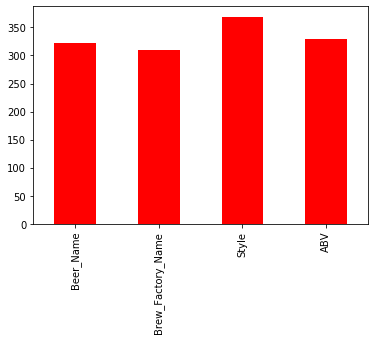

In [16]:
neg_ri_norms.sum().plot.bar(color='red')

In [17]:
neg_ri_norms.to_csv('experiment-results/testneg_ri_norms_hybrid.csv',index=False)

## Positive analysis

In [23]:
testpos_ri,testpos_ri_norms = computeRi(model.classifier,attributes,testpos,1)
torch.save(testpos_ri,'experiment-results/testpos_ri.pt')

100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


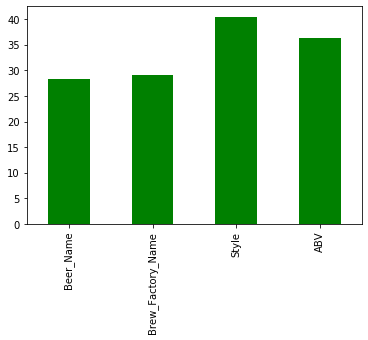

In [20]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar(color='green')

In [22]:
pos_ri_norms.to_csv('experiment-results/testpos_ri_norms.csv',index=False)

In [27]:
pos_ri,pos_ri_norms = computeRi(model.classifier,attributes,positives,1)
torch.save(pos_ri,'experiment-results/pos_ri.pt')

100%|██████████| 68/68 [00:04<00:00, 14.32it/s]


## Compute closer vectors

### Considering all samples

In [29]:
from utils.distance_measures import nearestNeighborsOnAttribute

In [26]:
##run this cell to load precomputed ri
positives_ri = torch.load('experiment-results/pos_ri.pt')
negatives_ri = torch.load('experiment-results/neg_ri.pt')

In [26]:
testpos_nn = nearestNeighborsOnAttribute(testpos,testpos_ri,
                                                       negatives,attributes,attribute_len)

100%|██████████| 14/14 [00:00<00:00, 363.79it/s]


In [30]:
positives_nn = nearestNeighborsOnAttribute(positives,pos_ri,
                                                       negatives,attributes,attribute_len)

100%|██████████| 68/68 [00:00<00:00, 420.56it/s]


In [29]:
testneg_nn = nearestNeighborsOnAttribute(testneg,testneg_ri,
                                                        positives,attributes,attribute_len)

100%|██████████| 77/77 [00:00<00:00, 497.15it/s]


In [30]:
testpos_nn.to_csv('experiment-results/testpos_NNhybrid.csv',index=False)
testneg_nn.to_csv('experiment-results/testneg_NNhybrid.csv',index=False)

In [31]:
positives_nn.to_csv('experiment-results/positives_NN_hybrid.csv',index=False)

## Extract patterns

In [14]:
import collections
from collections import OrderedDict

In [15]:
def countTokens(attributes):
    allTokens = {}
    for attr in attributes:
        tokens = list(map(lambda s:s.lower(),attr.split()))
        for tok in tokens:
            if tok in allTokens:
                allTokens[tok] += 1
            else:
                allTokens[tok] = 1
    allOrderedTokens = OrderedDict(sorted(allTokens.items(), key=lambda t: t[1]))
    return allOrderedTokens

In [35]:
testpos_nn = pd.read_csv('experiment-results/testpos_NNhybrid.csv')
positives_nn = pd.read_csv('experiment-results/positives_NN_hybrid.csv')
negatives = pd.read_csv('../../datasets/Structured/Beer/negatives.csv')

In [36]:
testpos_nn_values = testpos_nn.merge(negatives,left_on='Beer_Name',right_on='id')
positives_nn_values = positives_nn.merge(negatives,left_on='Beer_Name',right_on='id')

In [38]:
collections.Counter(countTokens(testpos_nn_values.ltable_Beer_Name.values)).most_common(5)

[('ale', 9), ('red', 8), ('amber', 6), ('fire', 3), ('brew', 3)]

In [39]:
collections.Counter(countTokens(testpos_nn_values.rtable_Beer_Name.values)).most_common(5)

[('ale', 9), ('red', 8), ('amber', 6), ('conshohocken', 3), ('hale', 3)]

In [40]:
collections.Counter(countTokens(positives_nn_values.ltable_Beer_Name.values)).most_common(5)

[('ale', 41), ('red', 35), ('amber', 19), ('the', 14), ('legends', 12)]

In [41]:
collections.Counter(countTokens(positives_nn_values.rtable_Beer_Name.values)).most_common(5)

[('ale', 41), ('red', 34), ('of', 24), ('amber', 19), ('the', 13)]